<a href="https://colab.research.google.com/github/girishmahale786/NLP-Lab/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classification on WELFake Dataset


Name: Girish Mahale  
PRN: 23070126504  
Batch: AI-ML B3

## Dataset Description

(WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

There are 78098 data entries in csv file out of which only 72134 entries are accessed as per the data frame.

In [1]:
# Mounting the google drive for loading the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries
import re
import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [3]:
# Downloading nltk_data
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [4]:
# Loading the dataset (stored in google drive)
df = pd.read_csv('/content/drive/MyDrive/WELFake_Dataset.csv', index_col=0)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
# Removing null values and duplicates, also only using title for the prediction
del df["text"]
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,title,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0
3,SATAN 2: Russia unvelis an image of its terrif...,1
4,About Time! Christian Group Sues Amazon and SP...,1


In [6]:
# Function to convert nltk pos tags to wordnet pos tags
def wn_pos(tag):
    valid_pos = ["n", "v", "a", "r", "s"]
    pos = tag.lower()[0]
    if pos not in valid_pos:
        return "n"
    return pos

# Function to clean and preprocess the text
def clean_text(text):
    text = re.sub(r'http://\S+|https://\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove symbols
    text = text.lower()  # Convert to lowercase
    text = text.strip() # Remove Whitespace

    # Tokenization
    tokens = word_tokenize(text)

    # POS tagging
    pos_tags = pos_tag(tokens)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, wn_pos(tag)) for token, tag in pos_tags]

    # Remove stopwords
    text = " ".join([word for word in tokens if word not in stopwords.words('english')])
    return text

# Applying preprocessing to the 'title' column
df["cleaned_title"] = df["title"].apply(clean_text)
df.head()

,title,label,cleaned_title
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,law enforcement high alert follow threat cop w...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,unbelievable obamas attorney general say charl...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0,bobby jindal raise hindu us story christian co...
3,SATAN 2: Russia unvelis an image of its terrif...,1,satan 2 russia unvelis image terrify new super...
4,About Time! Christian Group Sues Amazon and SP...,1,time christian group sue amazon splc designati...


In [7]:
# Splitting data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_title"], df["label"], test_size=0.2, random_state=42)

In [21]:
# Tokenization
def process_tokenizer(data, max_words):
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(data)
    return tokenizer

In [16]:
# Function to create and compile an LSTM model
def create_model(embedding_dim, max_sequence_length, lstm_units, max_words, layers):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
    if layers == 1:
        model.add(LSTM(lstm_units))
    else:
        model.add(LSTM(lstm_units, return_sequences=True))
        model.add(LSTM(lstm_units))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Function to train the model
def train_model(X_train, y_train, tokenizer, batch_size, max_sequence_length, embedding_dim, lstm_units, max_words, layers):
    X = tokenizer.texts_to_sequences(X_train)
    X = pad_sequences(X, maxlen=max_sequence_length)
    y = y_train.values
    model = create_model(embedding_dim, max_sequence_length, lstm_units, max_words, layers)
    model.fit(X, y, batch_size=batch_size, epochs=5, validation_split=0.2, verbose=1)
    return model

# Function to evaluate the model
def evaluate_model(model, tokenizer, X_test, y_test, max_sequence_length):
    X_test = tokenizer.texts_to_sequences(X_test)
    X_test = pad_sequences(X_test, maxlen=max_sequence_length)
    y_test = y_test.values
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [17]:
# Max sequence length based on the length of sentences in the dataset
max_sequence_length = max([len(x.split()) for x in X_train])

First Configuration:
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9976/9976 ━━━━━━━━━━━━━━━━━━━━ 135s 13ms/step - accuracy: 0.8190 - loss: 0.3810 - val_accuracy: 0.8918 - val_loss: 0.2588
Epoch 2/5
9976/9976 ━━━━━━━━━━━━━━━━━━━━ 136s 14ms/step - accuracy: 0.9176 - loss: 0.2064 - val_accuracy: 0.8988 - val_loss: 0.2467
Epoch 3/5
9976/9976 ━━━━━━━━━━━━━━━━━━━━ 143s 14ms/step - accuracy: 0.9328 - loss: 0.1687 - val_accuracy: 0.8967 - val_loss: 0.2502
Epoch 4/5
9976/9976 ━━━━━━━━━━━━━━━━━━━━ 145s 14ms/step - accuracy: 0.9472 - loss: 0.1371 - val_accuracy: 0.8961 - val_loss: 0.2636
Epoch 5/5
9976/9976 ━━━━━━━━━━━━━━━━━━━━ 139s 14ms/step - accuracy: 0.9561 - loss: 0.1143 - val_accuracy: 0.8926 - val_loss: 0.2904
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6818
           1       0.90      0.85      0.88      5653

    accuracy                           0.89     12471
   macro avg       0.89      0.89      0.89     12471
weighted avg       0.89      0.89    

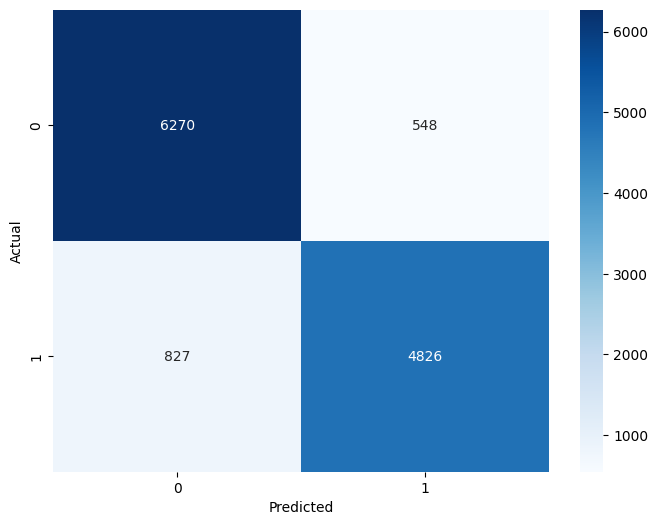

In [18]:
# First Configuration
batch_size = 4
embedding_dim = 10
max_words = 10000
lstm_units = 8

print("First Configuration:")
tokenizer = process_tokenizer(X_train, max_words)
model_1 = train_model(X_train, y_train, tokenizer, batch_size=batch_size, max_sequence_length=max_sequence_length, embedding_dim=embedding_dim, lstm_units=lstm_units, max_words=max_words, layers=1)
evaluate_model(model_1, tokenizer, X_test, y_test, max_sequence_length)

Second Configuration:
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4988/4988 ━━━━━━━━━━━━━━━━━━━━ 158s 31ms/step - accuracy: 0.8247 - loss: 0.3759 - val_accuracy: 0.8987 - val_loss: 0.2460
Epoch 2/5
4988/4988 ━━━━━━━━━━━━━━━━━━━━ 198s 30ms/step - accuracy: 0.9347 - loss: 0.1672 - val_accuracy: 0.8975 - val_loss: 0.2558
Epoch 3/5
4988/4988 ━━━━━━━━━━━━━━━━━━━━ 205s 31ms/step - accuracy: 0.9615 - loss: 0.1058 - val_accuracy: 0.8955 - val_loss: 0.3029
Epoch 4/5
4988/4988 ━━━━━━━━━━━━━━━━━━━━ 198s 30ms/step - accuracy: 0.9768 - loss: 0.0645 - val_accuracy: 0.8894 - val_loss: 0.3328
Epoch 5/5
4988/4988 ━━━━━━━━━━━━━━━━━━━━ 203s 30ms/step - accuracy: 0.9858 - loss: 0.0408 - val_accuracy: 0.8866 - val_loss: 0.4367
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      6818
           1       0.85      0.90      0.88      5653

    accuracy                           0.89     12471
   macro avg       0.88      0.89      0.88     12471
weighted avg       0.89      0.89    

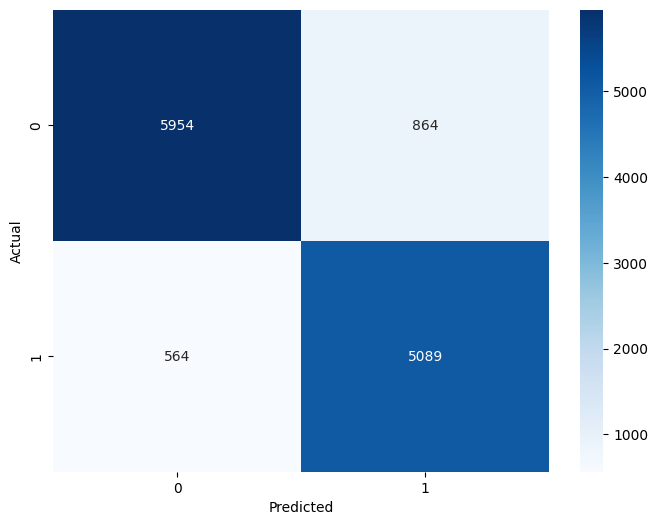

In [22]:
# Second Configuration
batch_size = 8
embedding_dim = 30
max_words = 25000
lstm_units = 16

print("Second Configuration:")
tokenizer = process_tokenizer(X_train, max_words)
model_2 = train_model(X_train, y_train, tokenizer, batch_size=batch_size, max_sequence_length=max_sequence_length, embedding_dim=embedding_dim, lstm_units=lstm_units, max_words=max_words, layers=2)
evaluate_model(model_2, tokenizer, X_test, y_test, max_sequence_length)

In [ ]:
# Results from Assignment 1

,Model,Vectorizer,Accuracy,Precision,Recall,F1-Score
5,RandomForestClassifier(),TfidfVectorizer(),0.885334,0.872337,0.871712,0.872024
4,RandomForestClassifier(),CountVectorizer(),0.880122,0.870297,0.860798,0.865521
0,LogisticRegression(),CountVectorizer(),0.831850,0.817801,0.803901,0.810791
1,LogisticRegression(),TfidfVectorizer(),0.828402,0.815323,0.797817,0.806475
3,SVC(),TfidfVectorizer(),0.820143,0.767338,0.859188,0.810669
2,SVC(),CountVectorizer(),0.819261,0.770391,0.850063,0.808268
